# Job Recommendation System

## Importing Lib

In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


sns.set_theme(context='notebook', style='darkgrid', palette='pastel')

tqdm.pandas()


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmedkandil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmedkandil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ahmedkandil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Reading the data

In [2]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///../data/jobs-2.db')
jobs_df = pd.read_sql('jobs', con=engine)

In [3]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451 entries, 0 to 2450
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        2451 non-null   object
 1   description  2451 non-null   object
dtypes: object(2)
memory usage: 38.4+ KB


In [4]:
jobs_df.isna().sum()

title          0
description    0
dtype: int64

In [5]:
jobs_df.duplicated().sum()

0

## EDA

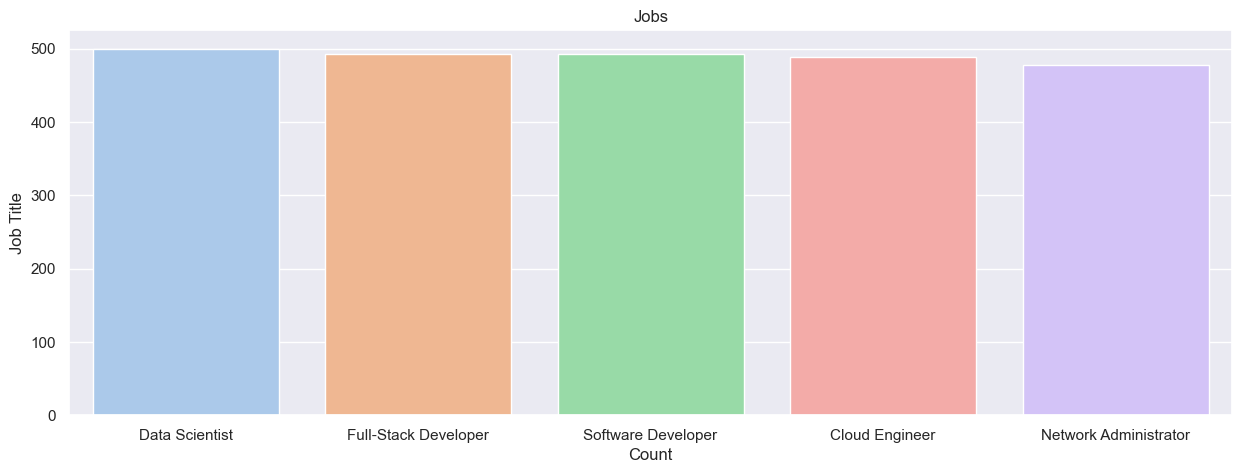

In [6]:
plt.figure(figsize=(15, 5))

job_title_counts = (jobs_df.title
                    .value_counts()
                    .sort_values(ascending=False)
                    .index
                    )
sns.countplot(data=jobs_df, x='title', order=job_title_counts)

plt.title('Jobs')
plt.xlabel('Count')
plt.ylabel('Job Title')

plt.show()

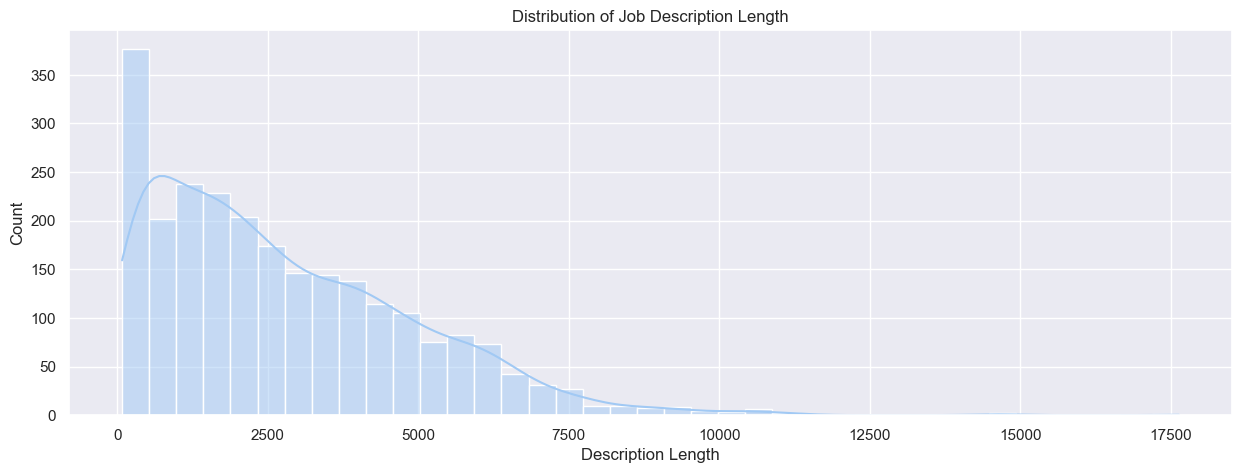

In [7]:
plt.figure(figsize=(15, 5))

sns.histplot(x=jobs_df.description.apply(len), kde=True)

plt.title('Distribution of Job Description Length')
plt.xlabel('Description Length')
plt.ylabel('Count')

plt.show()

## Data Cleaning

In [8]:
random_description = jobs_df.description.values[0]
random_description

'Collaborate with designers, product managers, and other stakeholders to gather requirements and translate them into technical specifications.\r\n'

In [9]:
random_description = re.sub(r'[^A-z]', ' ', random_description)
random_description = random_description.lower()

random_description

'collaborate with designers  product managers  and other stakeholders to gather requirements and translate them into technical specifications   '

In [10]:
random_description = word_tokenize(random_description)

random_description

['collaborate',
 'with',
 'designers',
 'product',
 'managers',
 'and',
 'other',
 'stakeholders',
 'to',
 'gather',
 'requirements',
 'and',
 'translate',
 'them',
 'into',
 'technical',
 'specifications']

In [11]:
stop_words = set(stopwords.words('english') + ['job', 'description'])
random_description = [
    word for word in random_description if word not in stop_words]

random_description

['collaborate',
 'designers',
 'product',
 'managers',
 'stakeholders',
 'gather',
 'requirements',
 'translate',
 'technical',
 'specifications']

In [12]:
lemma = WordNetLemmatizer()
random_description = [lemma.lemmatize(word) for word in random_description]

random_description

['collaborate',
 'designer',
 'product',
 'manager',
 'stakeholder',
 'gather',
 'requirement',
 'translate',
 'technical',
 'specification']

In [13]:
# Removal of Special Characters
def remove_characters(description):
    return re.sub(r'[^A-z]', ' ', description).lower()

# Tokenize


def tokenize(description):
    return word_tokenize(description)

# Removal of stopwords


def remove_stopwords(description):
    stop_words = set(stopwords.words('english') + ['job', 'description'])
    return [word for word in description if word not in stop_words]

# Lemmatization


def lemmatization(description):
    lemma = WordNetLemmatizer()
    return [lemma.lemmatize(word) for word in description]

# Total function


def cleaning(description):
    description = remove_characters(description)
    description = tokenize(description)
    description = remove_stopwords(description)
    description = lemmatization(description)

    return ' '.join(description)

In [14]:
jobs_df['clean_description'] = jobs_df.description.progress_apply(cleaning)

  0%|          | 0/2451 [00:00<?, ?it/s]

In [15]:
jobs_df

,title,description,clean_description
0,Full-Stack Developer,"Collaborate with designers, product managers, ...",collaborate designer product manager stakehold...
1,Network Administrator,The IT Network Administrator – Senior supports...,network administrator senior support network i...
2,Cloud Engineer,Job Describtion\r\n\r\nNC FAST requires a Seni...,describtion nc fast requires senior cloud engi...
3,Network Administrator,Shadow and partially participate the deploymen...,shadow partially participate deployment phase ...
4,Software Developer,Date Posted:\n2023-03-21\n...\nCountry:\nUnite...,date posted country united state america locat...
...,...,...,...
2446,Software Developer,Job Responsibilities\r\n\r\nThe Software Engin...,responsibility software engineer key role goli...
2447,Data Scientist,"This position is available in Montréal, Canada...",position available montr al canada visa sponso...
2448,Full-Stack Developer,Title: Senior Level Full Stack LEAD Developer\...,title senior level full stack lead developer n...
2449,Data Scientist,​​About LegalZoom\n\nWe're here to make legal ...,legalzoom make legal help accessible legalzoom...


In [16]:
jobs_df['description_len'] = jobs_df.description.apply(len)
jobs_df['clean_description_len'] = jobs_df.clean_description.apply(len)

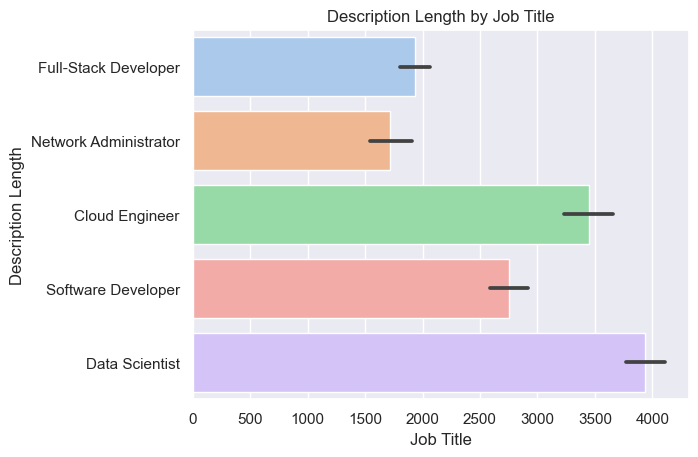

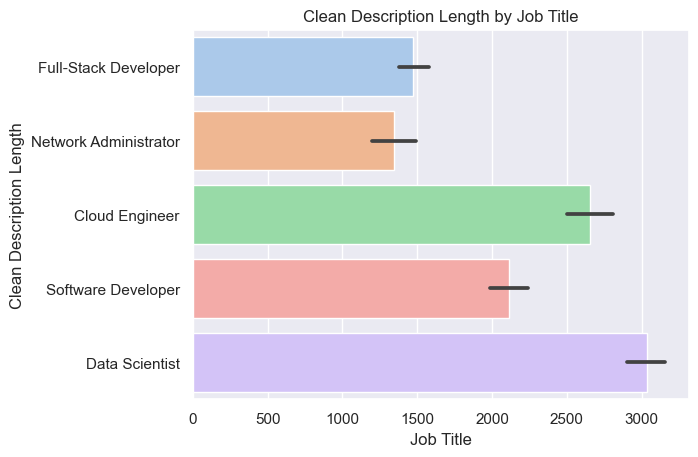

In [23]:
sns.barplot(data=jobs_df, x='description_len', y='title')
plt.title('Description Length by Job Title')
plt.xlabel('Job Title')
plt.ylabel('Description Length')
plt.show()

sns.barplot(data=jobs_df, x='clean_description_len', y='title')
plt.title('Clean Description Length by Job Title')
plt.xlabel('Job Title')
plt.ylabel('Clean Description Length')
plt.show()

## Model

In [ ]:
x = jobs_df.clean_description
y = jobs_df.title

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)

x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

### SVM

In [ ]:
model = SVC(random_state=42)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

### KNN

In [ ]:
model = KNeighborsClassifier(random_state=42)

In [ ]:
model.fit(x_train, y_train)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

### Random Forest

In [11]:
model = RandomForestClassifier(random_state=42)

In [12]:
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
y_pred = model.predict(x_test)

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 87.78%


### Hyperparameter Tuning and Overfitting

#### `n_estimators`

In [15]:
def n_estimators_error(n):
    model = RandomForestClassifier(n_estimators=n, n_jobs=-1, random_state=42)
    model.fit(x_train, y_train)

    train_acc = 1 - model.score(x_train, y_train)
    val_acc = 1 - model.score(x_test, y_test)

    return {
        'n_estimators': n,
        'training_error': train_acc,
        'validation_error': val_acc,
    }

In [16]:
%%time
n_estimators_df = pd.DataFrame([n_estimators_error(n) for n in range(1000, 5001, 1000)]).set_index('n_estimators')

CPU times: user 2min 9s, sys: 10.6 s, total: 2min 19s
Wall time: 27 s


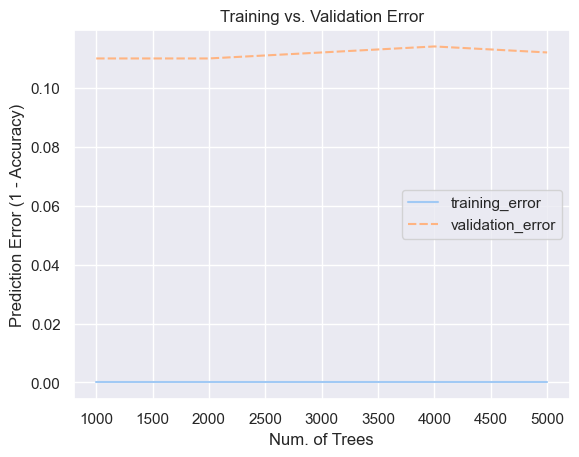

In [17]:
sns.lineplot(data=n_estimators_df)

plt.title('Training vs. Validation Error')
plt.xlabel('Num. of Trees')
plt.ylabel('Prediction Error (1 - Accuracy)')

plt.show()

#### `max_depth`

In [18]:
def max_depth_error(md):
    model = RandomForestClassifier(max_depth=md, n_jobs=-1, random_state=42)
    model.fit(x_train, y_train)

    train_acc = 1 - model.score(x_train, y_train)
    val_acc = 1 - model.score(x_test, y_test)

    return {
        'max_depth': md,
        'training_error': train_acc,
        'validation_error': val_acc,
    }

In [19]:
%%time
max_depth_df = pd.DataFrame([max_depth_error(md) for md in range(1, 31)]).set_index('max_depth')

CPU times: user 19.2 s, sys: 2.38 s, total: 21.6 s
Wall time: 4.97 s


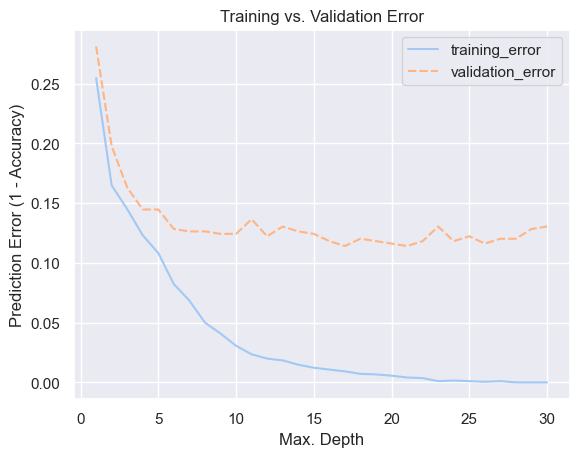

In [20]:
sns.lineplot(data=max_depth_df)

plt.title('Training vs. Validation Error')
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')

plt.show()

#### `min_samples_split`

In [21]:
def min_samples_split_error(mss):
    model = RandomForestClassifier(
        min_samples_split=mss, n_jobs=-1, random_state=42)
    model.fit(x_train, y_train)

    train_acc = 1 - model.score(x_train, y_train)
    val_acc = 1 - model.score(x_test, y_test)

    return {
        'min_samples_split': mss,
        'training_error': train_acc,
        'validation_error': val_acc,
    }

In [22]:
%%time
min_samples_split_df = pd.DataFrame([min_samples_split_error(mss) for mss in range(2, 31)]).set_index('min_samples_split')

CPU times: user 21.5 s, sys: 2.18 s, total: 23.7 s
Wall time: 5.18 s


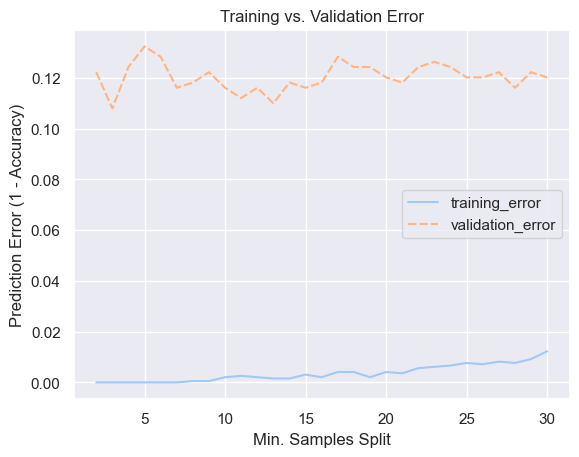

In [23]:
sns.lineplot(data=min_samples_split_df)

plt.title('Training vs. Validation Error')
plt.xlabel('Min. Samples Split')
plt.ylabel('Prediction Error (1 - Accuracy)')

plt.show()

#### `Best Model`

In [24]:
model = RandomForestClassifier(n_estimators=1000,
                               max_depth=25,
                               min_samples_split=25,
                               n_jobs=-1,
                               random_state=42)

In [25]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 88.39%


## Evaluate the Model

In [26]:
report = classification_report(y_test, y_pred)
print(report)

                       precision    recall  f1-score   support

       Cloud Engineer       0.94      0.89      0.92        94
       Data Scientist       0.97      0.98      0.98       101
 Full-Stack Developer       0.75      0.82      0.79        80
Network Administrator       0.88      0.96      0.92       112
   Software Developer       0.86      0.75      0.80       104

             accuracy                           0.88       491
            macro avg       0.88      0.88      0.88       491
         weighted avg       0.89      0.88      0.88       491



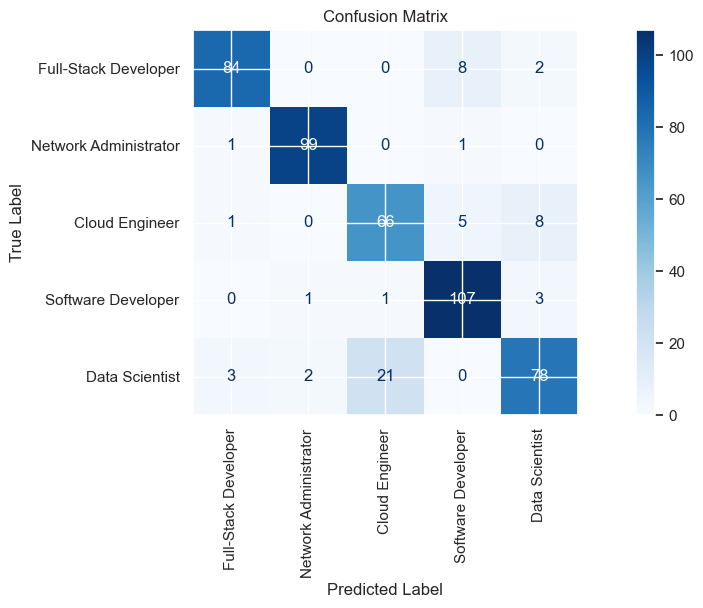

In [27]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(15, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=jobs_df.title.unique())
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()